In [61]:
import cv2
import numpy as np
import os
from sklearn.model_selection import train_test_split
from skimage.filters import frangi

# Set constants
NUM_INPUT_FRAMES = 10
NUM_OUTPUT_FRAMES = 20
FRAME_HEIGHT = 160
FRAME_WIDTH = 280
CHANNELS = 1
CROP_BOTTOM = 20  # Number of pixels to crop from the bottom

# Adjust contrast and brightness
CONTRAST = 1   # Contrast multiplier (1.0 means no change)
BRIGHTNESS = 0  # Brightness addition (0 means no change)

# Sigmoid adjustment parameters
SIGMOID_STRENGTH = 15  # Controls how sharply values are pushed to 0 or 1
SIGMOID_MIDPOINT = 0.2  # Midpoint where the sigmoid starts pushing values towards 0 or 1

# Folder containing neuron growth videos
video_folder = '../Videos_from_Genesis-20241022T191317Z-001'  # Replace with your folder path

# Helper function to preprocess frames
def preprocess_frame(frame):
    # Crop the bottom part of the frame to remove text
    cropped_frame = frame[:-CROP_BOTTOM, :, :] if CHANNELS == 3 else frame[:-CROP_BOTTOM, :]
    
    # # Resize back to the original dimensions (160x280)
    # resized_frame = cv2.resize(cropped_frame, (FRAME_WIDTH, FRAME_HEIGHT))
    
    # # # Bilateral filter for edge-preserving smoothing
    # resized_frame = cv2.GaussianBlur(resized_frame, (3, 3), 0)

    # # Step 3: Edge-preserving filter (Bilateral Filter)
    # resized_frame = cv2.bilateralFilter(resized_frame, d=3, sigmaColor=75, sigmaSpace=75)

    # # Step 5: Frangi filter for neurite enhancement
    # resized_frame = frangi(resized_frame)

    # Adjust contrast and brightness
    adjusted_frame = cv2.convertScaleAbs(cropped_frame, alpha=CONTRAST, beta=BRIGHTNESS)
    
    # Ensure the frame is in grayscale and uint8 format
    if CHANNELS == 1:
        adjusted_frame = cv2.cvtColor(adjusted_frame, cv2.COLOR_BGR2GRAY)
    adjusted_frame = adjusted_frame.astype(np.uint8)
    
    # # Step 1: Denoising
    # denoised_frame = cv2.fastNlMeansDenoising(adjusted_frame, h=10, templateWindowSize=7, searchWindowSize=21)
    
    # # Step 2: Contrast Adjustment using CLAHE
    # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # contrast_adjusted = clahe.apply(adjusted_frame)
    
    # Step 3: Sharpening Filter
    sharpen_kernel = np.array([[-1, -1, -1],
                               [-1, 9, -1],
                               [-1, -1, -1]])
    sharpened_frame = cv2.filter2D(adjusted_frame, -1, sharpen_kernel)
    
    # Step 1: Denoising
    denoised_frame = cv2.fastNlMeansDenoising(sharpened_frame, h=10, templateWindowSize=7, searchWindowSize=21)
    
    # # # Bilateral filter for edge-preserving smoothing
    denoised_frame = cv2.GaussianBlur(denoised_frame, (3, 3), 0)

    # denoised_frame = cv2.filter2D(denoised_frame, -1, sharpen_kernel)
    
    # Step 3: Sharpening Filter
    sharpened_frame = cv2.filter2D(adjusted_frame, -1, sharpen_kernel)

    # Normalize the frame to range [0, 1]
    normalized_frame = denoised_frame / 255.0

    # Step 4: Sigmoid Adjustment to Push Values Toward 0 or 1
    pushed_frame = 1 / (1 + np.exp(-SIGMOID_STRENGTH * (normalized_frame - SIGMOID_MIDPOINT)))

    # Resize back to the original dimensions (160x280)
    pushed_frame = cv2.resize(pushed_frame, (FRAME_WIDTH, FRAME_HEIGHT))

    return pushed_frame

# Helper function to sample frames
def sample_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, frame_count - 1, num=num_frames, dtype=int)
    frames = []

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (FRAME_WIDTH, FRAME_HEIGHT + CROP_BOTTOM))  # Load with extra height for cropping
            frame = preprocess_frame(frame)
            frames.append(frame)
        else:
            break
    cap.release()
    frames = np.array(frames).reshape(-1, FRAME_HEIGHT, FRAME_WIDTH, CHANNELS)
    return frames

# Load and process videos
X_data, Y_data = [], []
for video_name in os.listdir(video_folder):
    video_path = os.path.join(video_folder, video_name)
    frames = sample_frames(video_path, NUM_INPUT_FRAMES + NUM_OUTPUT_FRAMES)
    if frames.shape[0] >= NUM_INPUT_FRAMES + NUM_OUTPUT_FRAMES:
        X_data.append(frames[:NUM_INPUT_FRAMES])
        Y_data.append(frames[NUM_INPUT_FRAMES:NUM_INPUT_FRAMES + NUM_OUTPUT_FRAMES])

# Convert lists to numpy arrays
X_data = np.array(X_data)
Y_data = np.array(Y_data)

# Split the data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Print final shapes to confirm
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (53, 10, 160, 280, 1)
Y_train shape: (53, 20, 160, 280, 1)
X_val shape: (11, 10, 160, 280, 1)
Y_val shape: (11, 20, 160, 280, 1)
X_test shape: (12, 10, 160, 280, 1)
Y_test shape: (12, 20, 160, 280, 1)


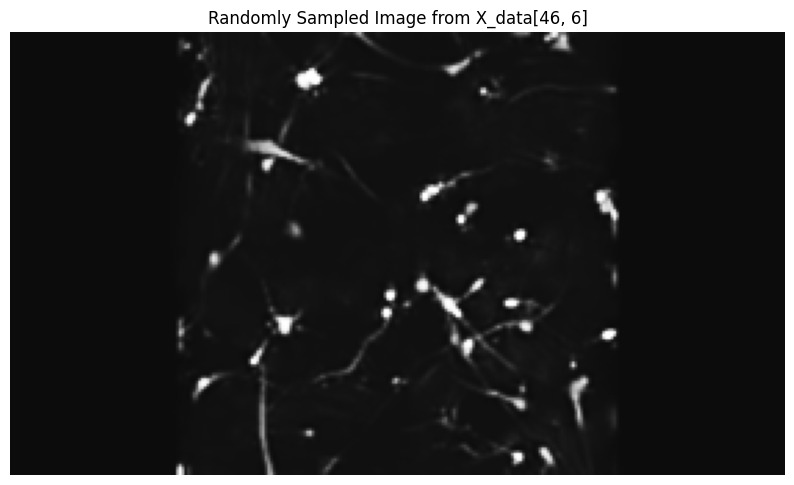

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot a single image
def plot_image(image, title="Image"):
    """
    Plots a single image.
    :param image: Input image (grayscale or color).
    :param title: Title of the plot.
    """
    # If image has an extra channel dimension, squeeze it to 2D for grayscale display
    if image.shape[-1] == 1:
        image = image.squeeze()
    
    # Plot the image
    plt.figure(figsize=(10, 10))  # Increase the figure size (width, height)
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None, vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage with random sampling
random_sample_index = np.random.randint(0, X_data.shape[0])  # Randomly select a sample from X_data
random_time_step = np.random.randint(0, X_data.shape[1])     # Randomly select a time step for the sample

# Select the random frame
sample_frame = X_data[random_sample_index, random_time_step]  # Select the random sample frame
plot_image(sample_frame, title=f"Randomly Sampled Image from X_data[{random_sample_index}, {random_time_step}]")


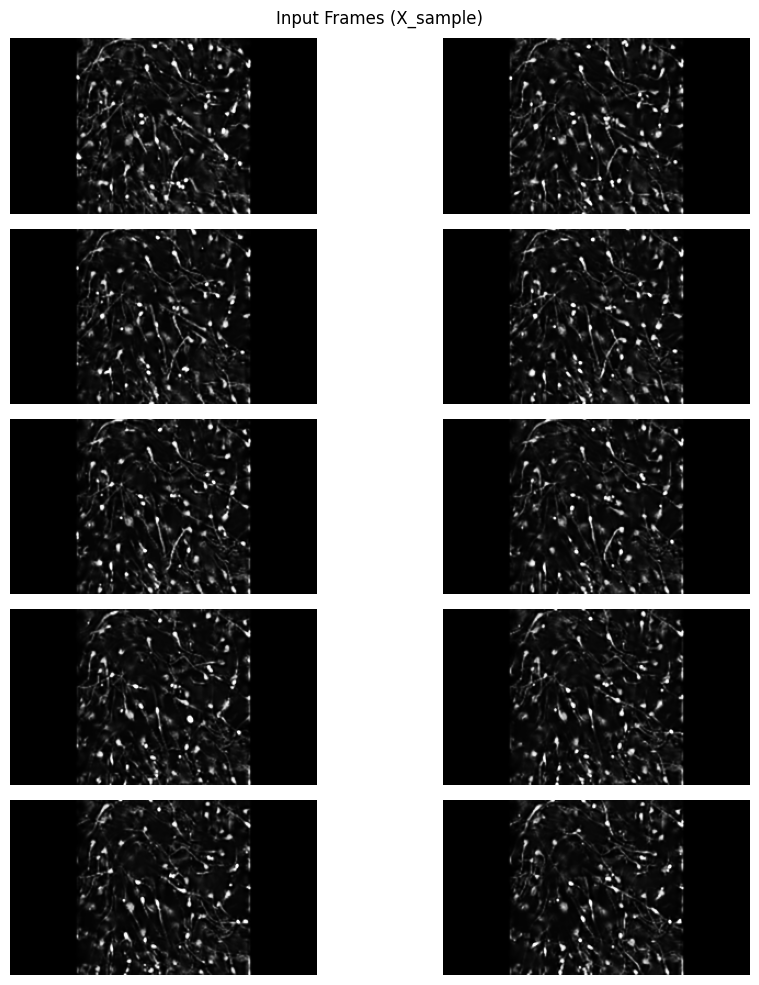

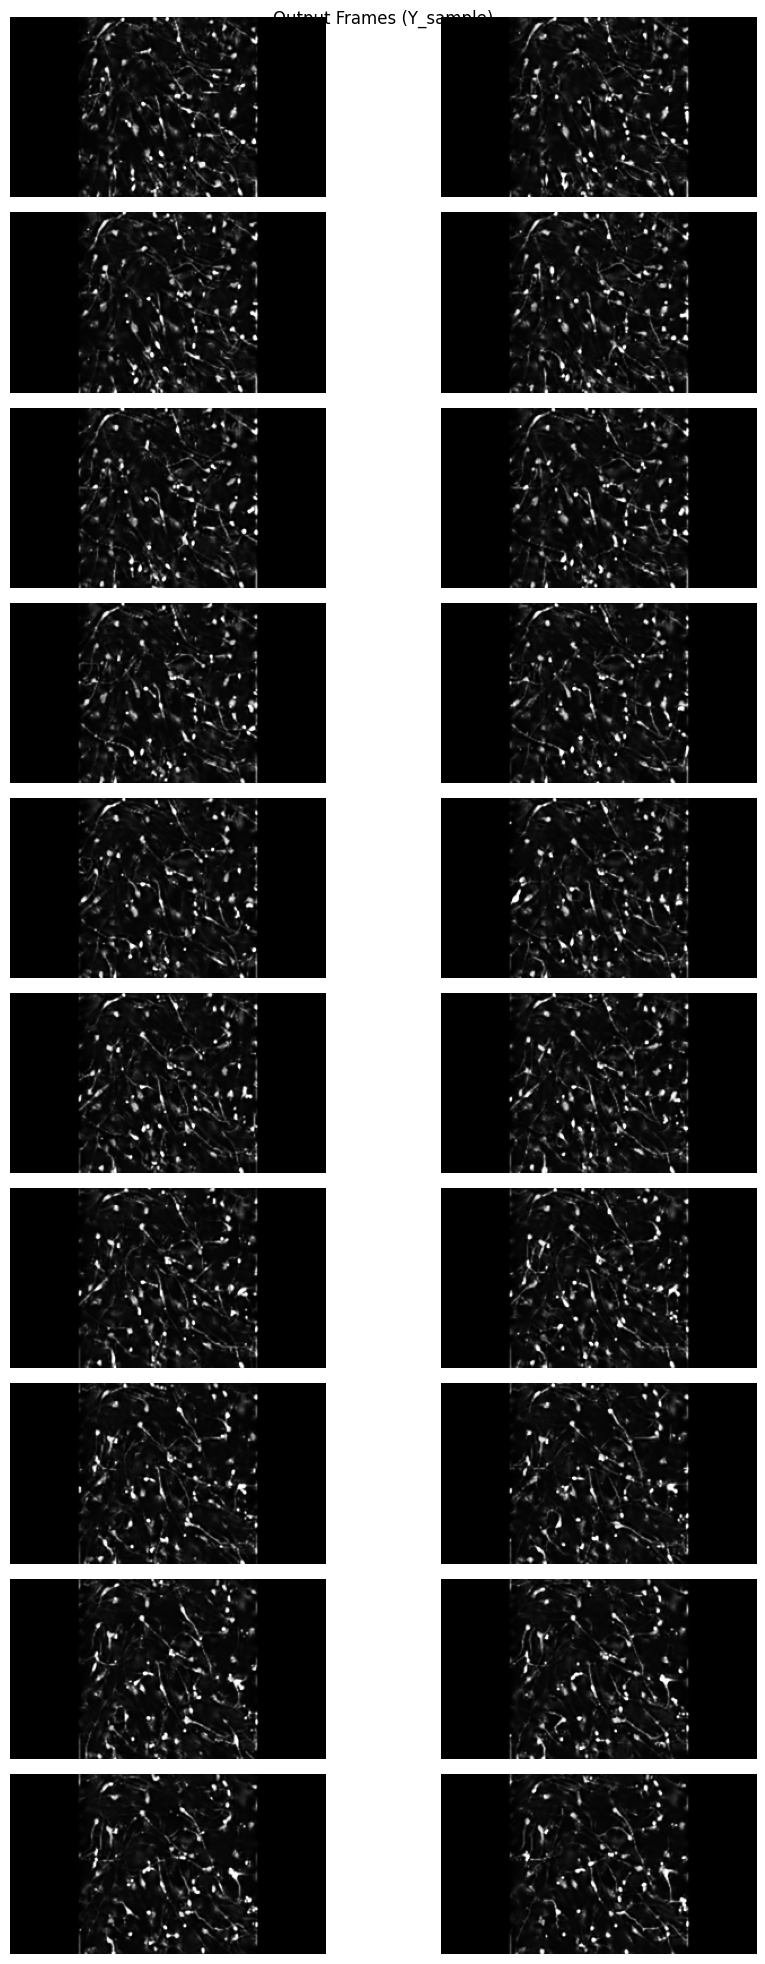

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Randomly select an index for the sample case
random_index = random.randint(0, len(X_data) - 1)

# Retrieve the input and output frames for the sampled case
X_sample = X_data[random_index]  # Shape: (10, 160, 280, 1)
Y_sample = Y_data[random_index]  # Shape: (20, 160, 280, 1)

# Plotting function for the frames in a 2-column layout
def plot_frames_2col(frames, title):
    num_frames = frames.shape[0]
    cols = 2
    rows = (num_frames + 1) // cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(rows, cols, figsize=(10, rows * 2))
    fig.suptitle(title)

    # Plot each frame
    for i in range(num_frames):
        row = i // cols
        col = i % cols
        ax = axes[row, col]
        ax.imshow(frames[i, :, :, 0], cmap='gray')
        ax.axis('off')

    # Hide any unused subplots
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()

# Plot input frames (10 frames in 2 columns)
plot_frames_2col(X_sample, title="Input Frames (X_sample)")

# Plot output frames (20 frames in 2 columns)
plot_frames_2col(Y_sample, title="Output Frames (Y_sample)")


In [64]:
# Split the data into train, validation, and test sets
print("Splitting data into train, validation, and test sets...")
X_train, X_temp, Y_train, Y_temp = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Print final shapes to confirm
print("Data split complete.")
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


Splitting data into train, validation, and test sets...
Data split complete.
X_train shape: (53, 10, 160, 280, 1)
Y_train shape: (53, 20, 160, 280, 1)
X_val shape: (11, 10, 160, 280, 1)
Y_val shape: (11, 20, 160, 280, 1)
X_test shape: (12, 10, 160, 280, 1)
Y_test shape: (12, 20, 160, 280, 1)


In [ ]:
import pickle

# Assuming X_train, Y_train, X_val, Y_val, X_test, and Y_test are already defined
# Reformat the dataset into a dictionary
dataset = {
    'X_train': X_train,
    'Y_train': Y_train,
    'X_val': X_val,
    'Y_val': Y_val,
    'X_test': X_test,
    'Y_test': Y_test
}

# Save the dataset to a .pkl file using pickle
with open('./reformatedNDDs/dataset_experiment_video_11012024.pkl', 'wb') as f:
    pickle.dump(dataset, f)

print("Dataset saved successfully as 'dataset_experiment_video_11012024.pkl'")


Dataset saved successfully as 'dataset_16k_20k.pkl'
